# Compute Terrestrial Water Storage anomalies from GRACE-FO data
*Author: R. Rietbroek Feb 2024 (r.rietbroek@utwente.nl)*

Since 2002, GRACE and its follow-on mission GRACE-FO have been providing monthly fields of so-called Stokes coefficients. These spherical harmonic coefficients represent gravity changes which are predominantly linked to the redistribution of water. The combined effect of those mass changes are captured as the [Essential Climate Variable Terrestrial Water Storage (TWS)](https://gcos.wmo.int/en/essential-climate-variables/tws).

Stokes coefficients from the GRACE solutions can be converted to an equivalent water height, but several processing steps are often needed to obtain good results. This notebook provides an example for applying the following steps:

* Obtain time-anomalies by subtracting a static gravity field from the monthly solutions
* *Todo:* Substitute the less accurate degree 2 coefficientsi with alternatives from a Satellite Laser Ranging solution (optional)
* *Todo:* Add degree 1 variations, which are needed to resolve for the Earth's wobbly around it's center of mass
* Filter the coefficients to remove high degreee noise
* Map (spherical harmonic synthesis) the results to a geographical area

The data used in this example is a sample extracted from a [geoslurp enabled] PostGreSQl database, the file links and their metadata are organized in a sql database, for easier matching (e.g. in time), but the use of a database or sql file is not strictly necessary.



In [1]:
#Optionally enable autoreloading for development purposes. Note that this does not automagically reload the binary extensions
%load_ext autoreload
%autoreload 2
#also supress some warnings from pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. Load the necessary python modules

In [2]:
import xarray as xr
import shxarray
import numpy as np
import os
import gzip
import sqlite3
import tarfile
import matplotlib.pyplot as mpl

## 2. Load the sample data from the tarball (making use of the tables in the sqlite file)
shxarray can open files in various formats (e.g. [icgem](http://icgem.gfz-potsdam.de/home) or the common GSM-V6 format used in many GRACE processing centers). When installing shxarray, these methods become available to Xarray. The methods are exposed through choosing an appropriate engine in Xarray `open_dataset` function, e.g.:

```
dsicgem=xr.open_dataset(icgemfilename,engine="icgem")
dsgsmv6=xr.open_dataset(GSMV6filename,engine="gsmv6")

```
Gzipped compressed file are also allowed (ending in `.gz`).

Alternatively, one can pass an open file descriptor to the open_dataset call. This latter way is used below.

In [3]:
# Helper class which aids in extracing the gzipped data files from the Tar file without the need to extract the data to the disk
class TarExtracter:
    def __init__(self,tararchive):
        """ Opens a tararchive and keep its open acces point available to functions within this class"""
        self.tarar=tarfile.open(os.path.join(datadir,tararchive),'r:gz')
    def getmember(self,member):
        """Extract a specific (gzipped) member from an open archive, and return an open file object"""
        tarfileobj=self.tarar.extractfile(member)
        return gzip.open(tarfileobj)
    def close(self):
        self.tarar.close()
      
    

In [4]:
#The SQLITE database holds an inventory of the sample data
datadir='../../../sample-data'
sqlfile=os.path.join(datadir,'GRACEDataSample_2020.sql')

conn=sqlite3.connect(sqlfile)

print(f"Tables present in the sqlite3 file {sqlfile}:")
for res in conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall():
    print(f"\tTable {res[0]}")

tarname,staticgravmem=conn.execute("SELECT * FROM static LIMIT 1").fetchone()[13].split(":")
tarar=TarExtracter(tarname)

# read the time-invariable Stokes Coefficients
with tarar.getmember(staticgravmem) as fid:
    dsstatic=xr.open_dataset(fid,engine="icgem")

# read the time variable Stokes coefficients
gsm=[]
gaa=[]
for res in conn.execute(f"SELECT gsm,gaa FROM gracel2").fetchall():
    
    print(f"Reading {res[0]}")
    with tarar.getmember(res[0].split(":")[1]) as fid:
        gsm.append(xr.open_dataset(fid,engine="gsmv6"))
    
    print(f"Reading {res[1]}")
    with tarar.getmember(res[1].split(":")[1]) as fid:
        gaa.append(xr.open_dataset(fid,engine="gsmv6"))
        
dsgsm=xr.concat(gsm,dim="time")
dsgaa=xr.concat(gaa,dim="time")

tarar.close()

Tables present in the sqlite3 file ../../../sample-data/GRACEDataSample_2020.sql:
	Table gracel2
	Table static
Reading GRACEDataSample_2020_files.tgz:gracefol2_jpl_rl06/GSM-2_2020001-2020031_GRFO_JPLEM_BA01_0600.gz
Reading GRACEDataSample_2020_files.tgz:gracefol2_jpl_rl06/GAA-2_2020001-2020031_GRFO_JPLEM_BC01_0600.gz
Reading GRACEDataSample_2020_files.tgz:gracefol2_jpl_rl06/GSM-2_2020032-2020060_GRFO_JPLEM_BA01_0600.gz
Reading GRACEDataSample_2020_files.tgz:gracefol2_jpl_rl06/GAA-2_2020032-2020060_GRFO_JPLEM_BC01_0600.gz
Reading GRACEDataSample_2020_files.tgz:gracefol2_jpl_rl06/GSM-2_2020061-2020091_GRFO_JPLEM_BA01_0600.gz
Reading GRACEDataSample_2020_files.tgz:gracefol2_jpl_rl06/GAA-2_2020061-2020091_GRFO_JPLEM_BC01_0600.gz
Reading GRACEDataSample_2020_files.tgz:gracefol2_jpl_rl06/GSM-2_2020092-2020121_GRFO_JPLEM_BA01_0600.gz
Reading GRACEDataSample_2020_files.tgz:gracefol2_jpl_rl06/GAA-2_2020092-2020121_GRFO_JPLEM_BC01_0600.gz
Reading GRACEDataSample_2020_files.tgz:gracefol2_jpl_rl06

## 3. Create anomalies by subtracting the static gravity field from the monthly solutions

In [5]:
dsgsm["dcnm"]=dsgsm.cnm-dsstatic.cnm

# Optional: restore (add) gaa atmospheric monthly averaged dealiasing product
# dsgsm["dcnm"]=dsgsm.dcnm+dsgaa.cnm
nmax=dsgsm.sh.nmax

## 4. Convert to Terrestrial Water Storage

In [6]:
datws=dsgsm.dcnm.sh.tws()
display(datws)

shxarray-INFO: /home/roelof/.cache/shxarray_storage/Love/geoslurp_dump_llove.sql already exists, no need to download)


<xarray.DataArray 'tws' (time: 12, nm: 3717)>
array([[-0.02487564, -0.01694817,  0.01025854, ..., -0.01075089,
        -0.01266904,  0.00839316],
       [-0.01374138, -0.01561931,  0.01075172, ..., -0.00521706,
         0.04217609,  0.02398339],
       [-0.04159936, -0.01415217,  0.0110674 , ...,  0.00249756,
        -0.00918009,  0.00079155],
       ...,
       [-0.02353147, -0.01384392,  0.01395362, ...,  0.01916308,
        -0.00649175,  0.00465168],
       [-0.01776748, -0.0154328 ,  0.01047623, ...,  0.00197096,
        -0.02328258, -0.04190373],
       [-0.02346409, -0.02034968,  0.01014107, ..., -0.00991265,
        -0.00641819,  0.0473164 ]])
Coordinates:
  * nm       (nm) object MultiIndex
  * n        (nm) int64 2 2 2 2 2 3 3 3 3 3 3 ... 60 60 60 60 60 60 60 60 60 60
  * m        (nm) int64 0 1 -1 2 -2 0 1 -1 2 ... -56 57 -57 58 -58 59 -59 60 -60
  * time     (time) datetime64[ns] 2020-01-16T11:59:59.500000 ... 2020-12-16T...
Attributes:
    units:      m
    long_name:  Total water storage
    gravtype:   tws

## 5. Grid to a global grid and make a quick visualization of a certain month

/home/roelof/cld_UTwente/Soft/shxarray-git/src/shxarray/core/xr_accessor.py:14: AccessorRegistrationWarning: registration of accessor <class 'shxarray.core.xr_accessor.SHDaAccessor'> under name 'sh' for type <class 'xarray.core.dataarray.DataArray'> is overriding a preexisting attribute with the same name.
  @xr.register_dataarray_accessor("sh")
/home/roelof/cld_UTwente/Soft/shxarray-git/src/shxarray/core/xr_accessor.py:154: AccessorRegistrationWarning: registration of accessor <class 'shxarray.core.xr_accessor.SHDsAccessor'> under name 'sh' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  


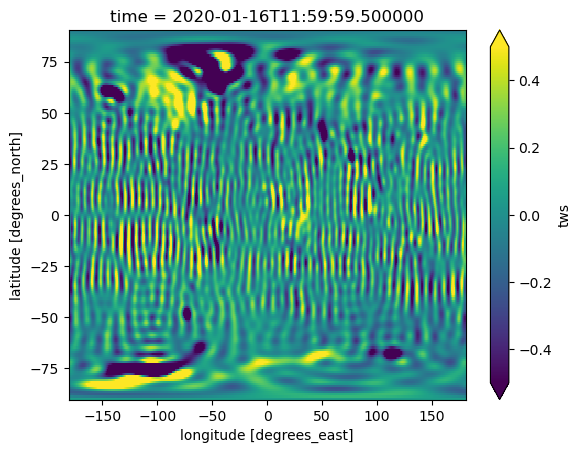

In [10]:
dsgrd=datws.sh.synthesis().to_dataset(name="tws")
islice=0
dsgrd.tws[:,:,islice].plot(vmin=-0.5,vmax=0.5)

## 6. Filtering of GRACE 
The North-South stripes in the plot above are due to correlated errors in the GRACE-FO data, and it makes it more difficult to use for e.g. hydrological applications.
This is why the GRACE(-FO) fields often require filtering. This is what we'll be doing next.


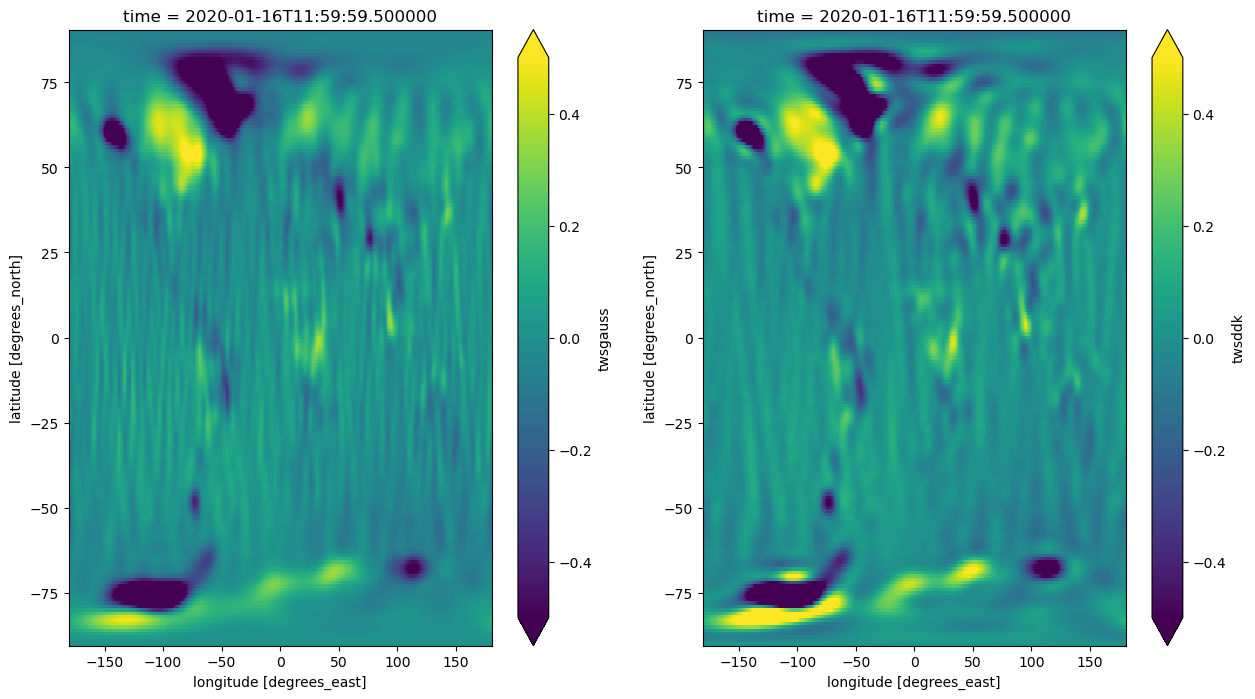

In [11]:
# filter before transforming to a grid
# Gaussian filter
dsgrd["twsgauss"]=datws.sh.filter('Gauss300').sh.synthesis()
# Anisotropic decorrelation filter
dsgrd["twsddk"]=datws.sh.filter('DDK4').sh.synthesis()

fig, axs = mpl.subplots(ncols=2,nrows=1,figsize=(15, 8))
vmin=-0.5
vmax=0.5

islice=0
dsgrd.twsgauss[:,:,islice].plot(ax=axs[0],vmin=vmin,vmax=vmax)
dsgrd.twsddk[:,:,islice].plot(ax=axs[1],vmin=vmin,vmax=vmax)

## 7. Visualize Time Series

Text(0.5, 1.0, 'GRACE follow on at location 43,3')

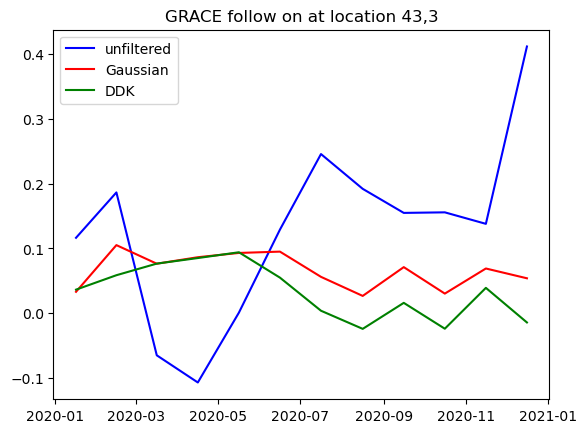

In [12]:
lon=43
lat=3
dseries=dsgrd.sel(lon=lon,lat=lat)

mpl.plot(dseries.time,dseries.tws,'b-',label='unfiltered')
mpl.plot(dseries.time,dseries.twsgauss,'r-',label='Gaussian')
mpl.plot(dseries.time,dseries['twsddk'],'g-',label='DDK')
mpl.legend()
mpl.title(f"GRACE follow on at location {lon},{lat}")

## 8. Interpretation
From the steps above one can observe that filtering of GRACE(-FO) has a pronounced impact in both the spatial and time domain. Unfortunately, filtering will remain necessary and there is generally no one-size-fits all solution. Studies in regions which have strong and large scale signals may get away with smaller filters, whereas capturing smaller signals require a carefull trade-off between noise reduction versus signal attenuation.